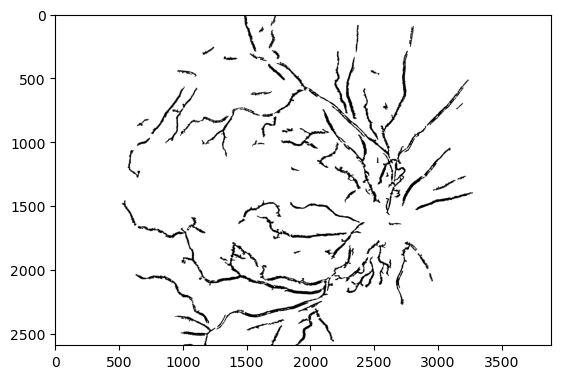

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_retina(image_path):
    # Read the input image
    image = cv2.imread(image_path)

    # Split the image channels
    b, green_fundus, r = cv2.split(image)

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_enhanced_green_fundus = clahe.apply(green_fundus)

    # Morphological operations for blood vessels detection
    r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations=1)
    R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations=1)
    r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11)), iterations=1)
    R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11)), iterations=1)
    r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23, 23)), iterations=1)
    R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23, 23)), iterations=1)

    # Subtract to get blood vessels
    f4 = cv2.subtract(R3, contrast_enhanced_green_fundus)

    # Apply CLAHE again
    f5 = clahe.apply(f4)

    # Thresholding
    ret, f6 = cv2.threshold(f5, 15, 255, cv2.THRESH_BINARY)

    # Masking
    mask = np.ones(f5.shape[:2], dtype="uint8") * 255
    contours, hierarchy = cv2.findContours(f6.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) <= 200:
            cv2.drawContours(mask, [cnt], -1, 0, -1)
    im = cv2.bitwise_and(f5, f5, mask=mask)

    # Thresholding and morphological operations
    ret, fin = cv2.threshold(im, 15, 255, cv2.THRESH_BINARY_INV)
    newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=1)

    # Erode again for blood vessels
    fundus_eroded = cv2.bitwise_not(newfin)

    # Contour analysis for identifying veins
    xmask = np.ones(fundus_eroded.shape[:2], dtype="uint8") * 255
    xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in xcontours:
        shape = "unidentified"
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
        if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
            shape = "circle"
        else:
            shape = "veins"
        if shape == "circle":
            cv2.drawContours(xmask, [cnt], -1, 0, -1)

    finimage = cv2.bitwise_and(fundus_eroded, fundus_eroded, mask=xmask)
    blood_vessels = cv2.bitwise_not(finimage)

    return blood_vessels


# Example usage:
image_path = "16_left.jpeg"
resulting_image = analyze_retina(image_path)
plt.imshow(resulting_image / 255, cmap='gray')
plt.show()